In [1]:
import h5py
import numpy as np
import pandas as pd
import scipy
from scipy import signal
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn import metrics
from tensorflow import keras
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
#from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

2023-04-04 20:43:41.915545: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
def getData(cfileName):

    # Read the *.cfile which has each element in float32 format.
    data = np.fromfile(cfileName, dtype="float32")

    # Take each consecutive interleaved I sample and Q sample to create a single complex element.
    data = data[0::2] + 1j*data[1::2]
    #print("data type=", type(data))
    # Return the complex numpy array.
    return data

def create_dataset(data, class_label):
    f, t, Zxx = signal.stft(data, fs=20e6, nperseg=fft_size, noverlap=fft_overlap)
    print(len(f))
    print(len(t))
    print(Zxx.shape)

    del data

    Zxx = Zxx.transpose()

    Zxx = abs(Zxx)
    # scaling the features (only real part of the data can be used)
    scaler = MinMaxScaler()
    scaler.fit(Zxx)
    print(scaler.data_max_)
    Zxx = scaler.transform(Zxx)

    X = Zxx[:num_samp_per_class]
    Y = np.full(num_samp_per_class, class_label)

    return X, Y

# number of samples per class
num_samp_per_class = 10000

# FFT size for the STFT operation (which is same as the feature vector size)
fft_size = feature_vector_size = 2048 #1024

# number of overlapping samples for the STFT operation
fft_overlap = 256

## Nordic Device-30(i) dataset

In [4]:
class_label = 8
for i in range(class_label):

    folder_path = "/Volumes/Transcend/PhD in Computing/Data Collection/Nordic/2.4GHz/Device-30(i)/"

    if(i==0):
        data = getData(folder_path + "BLINK_new.cfile")
        print(np.array(data))
        X, Y = create_dataset(data, i)

    else:

        if(i==1):
            data = getData(folder_path + "blinky_freertos.cfile")
            print(np.array(data))
            dataset, label = create_dataset(data, i)

        if(i==2):
            data = getData(folder_path + "blinky_rtc_freertos.cfile")
            print(np.array(data))
            dataset, label = create_dataset(data, i)

        if(i==3):
            data = getData(folder_path + "blinky_systick.cfile")
            print(np.array(data))
            dataset, label = create_dataset(data, i)

        if(i==4):
            data = getData(folder_path + "blinky.cfile")
            print(np.array(data))
            dataset, label = create_dataset(data, i)

        if(i==5):
            data = getData(folder_path + "IDLE_new.cfile")
            print(np.array(data))
            dataset, label = create_dataset(data, i)

        if(i==6):
            data = getData(folder_path + "led_softblink.cfile")
            print(np.array(data))
            dataset, label = create_dataset(data, i)

        if(i==7):
            data = getData(folder_path + "Matrix_MUL_new.cfile")
            print(np.array(data))
            dataset, label = create_dataset(data, i)

        X = np.concatenate((X, dataset), axis=0) 
        Y = np.concatenate((Y, label), axis=0)
        
    print(i)
    print(X.shape)
    print(Y.shape)

# combine all em signals into one dataframe
em_data = pd.DataFrame(X)
em_data.insert(len(em_data.columns), 'labels', Y)

# save to csv file
#(em_data.T).to_csv(f'/Users/Lojenaa/Documents/DELL_Linux/Lojenaa/HackRF One/Smartphones/Cross-device-Portability-of-EMSCA/Smartphones/iPhone/iPhone6S/i6S_I.csv', header=False)
# (em_data.T).to_csv(f'/Users/Lojenaa/Documents/PhD/Smartphones/Cross-device-Portability-of-EMSCA/Smartphones/iPhone/iPhone8/i8_I.csv', header=False)

[0.015625 +0.j        0.0234375+0.j        0.015625 +0.0078125j ...
 0.       +0.0078125j 0.0234375+0.j        0.0234375+0.j       ]
2048
96113
(2048, 96113)
[0.04646239 0.03328745 0.03656413 ... 0.02992783 0.0429942  0.0498788 ]
0
(10000, 2048)
(10000,)
[0.0078125-0.0078125j 0.       +0.015625j  0.03125  +0.j        ...
 0.015625 +0.j        0.0078125+0.j        0.0390625+0.015625j ]
2048
90115
(2048, 90115)
[0.02118785 0.01756276 0.02195976 ... 0.01779469 0.02509898 0.03127494]
1
(20000, 2048)
(20000,)
[0.015625 +0.j        0.0078125+0.0234375j 0.0234375+0.015625j  ...
 0.03125  +0.015625j  0.03125  +0.015625j  0.0078125+0.0078125j]
2048
77672
(2048, 77672)
[0.04712218 0.04057462 0.02913437 ... 0.02716755 0.03522654 0.03891793]
2
(30000, 2048)
(30000,)
[0.0234375+0.015625j  0.015625 +0.j        0.0234375+0.j        ...
 0.       +0.015625j  0.015625 +0.015625j  0.0234375-0.0078125j]
2048
73732
(2048, 73732)
[0.03594497 0.02562196 0.02509734 ... 0.01618464 0.01918358 0.03657822]
3
(40

## Cross-model Validation applying the Model of other set of samples

Nordic Device-25(i) model to Nordic Device-30(i) dataset 

In [5]:
model = keras.models.load_model("/Users/Lojenaa/Documents/PhD/Smartphones/Cross-device-Portability-of-EMSCA/Nordic/2.4GHz/Device-25/Nordic-device-25-Own_models/Nordic-25(i)_model.h5")

2023-04-04 21:19:13.068257: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [6]:
results = model.evaluate(X, Y)
print("test loss, test acc:", results)

2500/2500 [==============================] - 10s 4ms/step - loss: 12.8097 - accuracy: 0.0057
test loss, test acc: [12.80974292755127, 0.005687499884516001]


In [7]:
y_pred = np.argmax(model.predict(X), axis=-1)
print(y_pred)
print(y_pred[0])

print(confusion_matrix(Y, y_pred))
print(classification_report(Y, y_pred))

2500/2500 [==============================] - 10s 4ms/step
[3 3 3 ... 3 3 3]
3
[[   0  554    7 4933 4485    0   21    0]
 [   5   13 9768    1  151   46    6   10]
 [   0  729    7 8531  705    0   23    5]
 [   1 4571   15   47 5336    6   14   10]
 [   1 9571   20   14  346    5   25   18]
 [   0   90    2 9701  176    1   17   13]
 [   0 2305    2 7500  145    0   32   16]
 [   0   94    4 9770  101    0   22    9]]
              precision    recall  f1-score   support

           0       0.00      0.00      0.00     10000
           1       0.00      0.00      0.00     10000
           2       0.00      0.00      0.00     10000
           3       0.00      0.00      0.00     10000
           4       0.03      0.03      0.03     10000
           5       0.02      0.00      0.00     10000
           6       0.20      0.00      0.01     10000
           7       0.11      0.00      0.00     10000

    accuracy                           0.01     80000
   macro avg       0.05      0.01  

Test Accuracy:0.0056875


Text(0.5, 1.0, 'Accuracy:0.006')

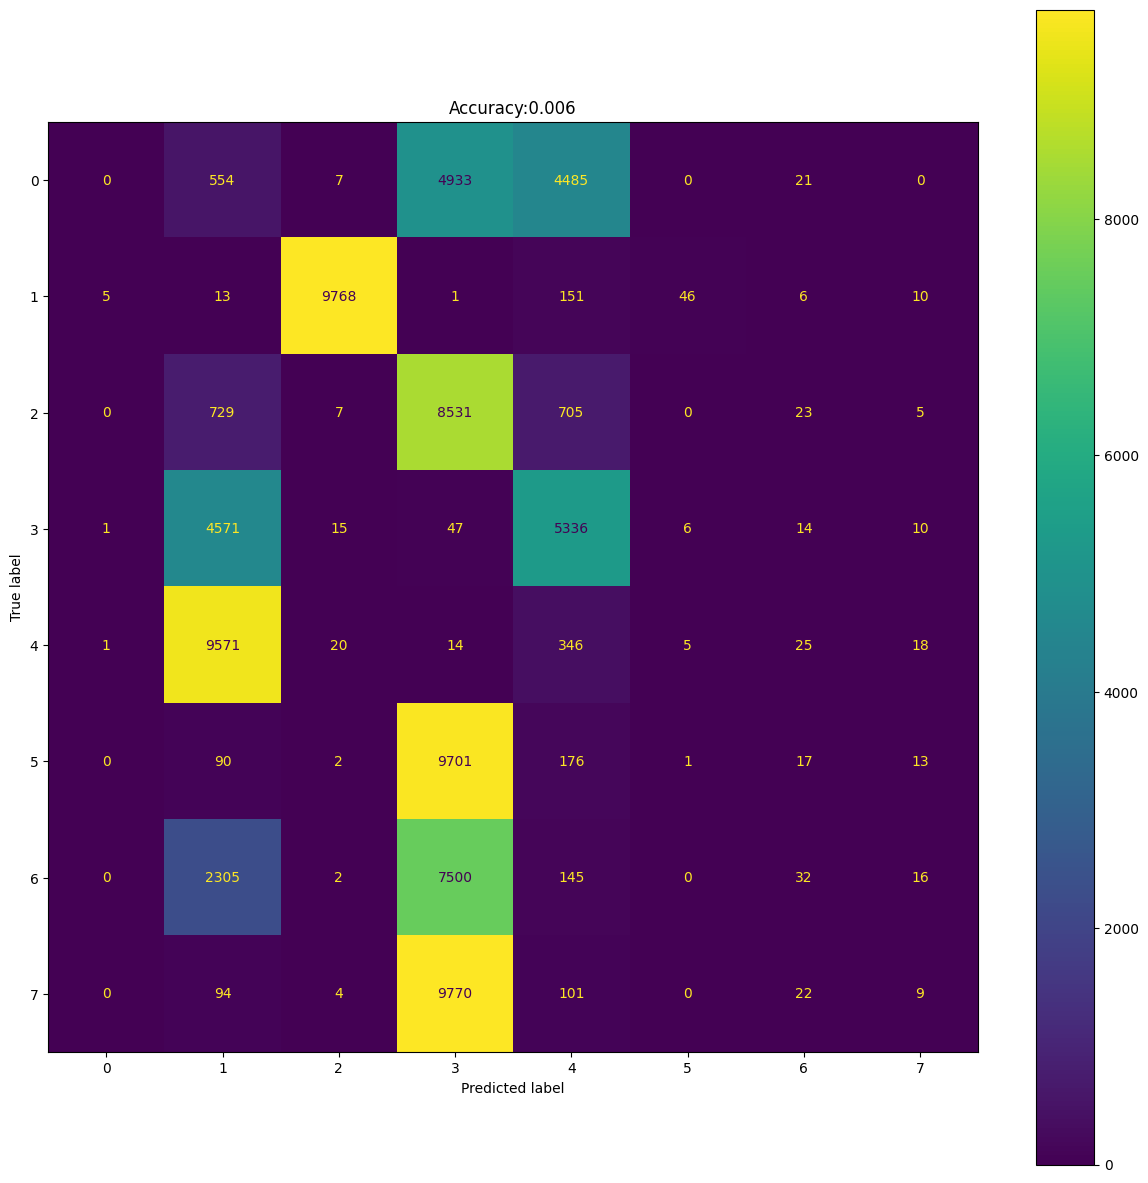

In [8]:
# confusion matrix plot
plt.rcParams["figure.figsize"] = (15,15)
fig, axs = plt.subplots(1)

test_acc = metrics.accuracy_score(y_pred,Y)
print(f"Test Accuracy:{test_acc}")
metrics.ConfusionMatrixDisplay.from_predictions(Y, y_pred, ax=axs)
plt.title(f"Accuracy:{test_acc:.3f}")
# plt.savefig(f'/Users/Lojenaa/Documents/PhD/Smartphones/Cross-device-Portability-of-EMSCA/Nordic/Device-25/iNordic-25(i)_confusion_matrix.pdf')

## Cross-model Validation by applying Transfer Learning of other Device's Model

Nordic Device-25(i) model to Nordic Device-30(i) dataset 

In [9]:
model = keras.models.load_model("/Users/Lojenaa/Documents/PhD/Smartphones/Cross-device-Portability-of-EMSCA/Nordic/2.4GHz/Device-25/Nordic-device-25-Own_models/Nordic-25(i)_model.h5")
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 1400)              2868600   
                                                                 
 dense_1 (Dense)             (None, 800)               1120800   
                                                                 
 dense_2 (Dense)             (None, 500)               400500    
                                                                 
 dense_3 (Dense)             (None, 200)               100200    
                                                                 
 dense_4 (Dense)             (None, 100)               20100     
                                                                 
 dense_5 (Dense)             (None, 8)                 808       
                                                                 
Total params: 4,511,008
Trainable params: 4,511,008
Non-

In [10]:
# Freeze all layers except the last one.
for layer in model.layers[:-1]:
  layer.trainable = False

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 1400)              2868600   
                                                                 
 dense_1 (Dense)             (None, 800)               1120800   
                                                                 
 dense_2 (Dense)             (None, 500)               400500    
                                                                 
 dense_3 (Dense)             (None, 200)               100200    
                                                                 
 dense_4 (Dense)             (None, 100)               20100     
                                                                 
 dense_5 (Dense)             (None, 8)                 808       
                                                                 
Total params: 4,511,008
Trainable params: 808
Non-traina

In [12]:
opt = keras.optimizers.SGD(learning_rate=0.001)
model.compile(loss="sparse_categorical_crossentropy", optimizer=opt, metrics=["accuracy"])

history = model.fit(X, Y, epochs=30)

Epoch 1/30
2500/2500 [==============================] - 10s 4ms/step - loss: 0.8476 - accuracy: 0.7903
Epoch 2/30
2500/2500 [==============================] - 10s 4ms/step - loss: 0.8449 - accuracy: 0.7918
Epoch 3/30
2500/2500 [==============================] - 9s 4ms/step - loss: 0.8422 - accuracy: 0.7915
Epoch 4/30
2500/2500 [==============================] - 9s 4ms/step - loss: 0.8395 - accuracy: 0.7923
Epoch 5/30
2500/2500 [==============================] - 10s 4ms/step - loss: 0.8370 - accuracy: 0.7929
Epoch 6/30
2500/2500 [==============================] - 9s 4ms/step - loss: 0.8344 - accuracy: 0.7926
Epoch 7/30
2500/2500 [==============================] - 9s 4ms/step - loss: 0.8320 - accuracy: 0.7929
Epoch 8/30
2500/2500 [==============================] - 10s 4ms/step - loss: 0.8294 - accuracy: 0.7934
Epoch 9/30
2500/2500 [==============================] - 10s 4ms/step - loss: 0.8271 - accuracy: 0.7947
Epoch 10/30
2500/2500 [==============================] - 10s 4ms/step - loss:

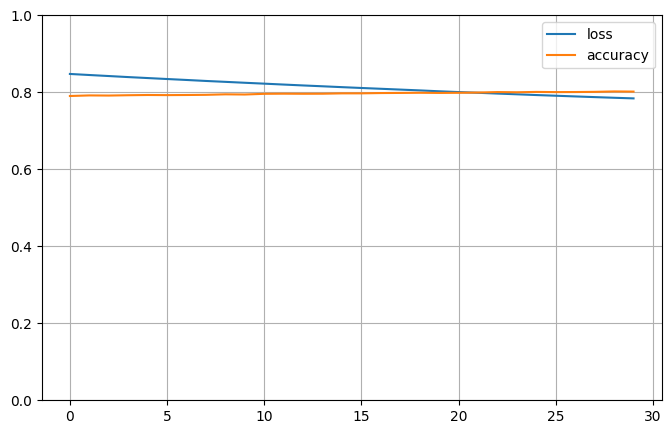

In [13]:
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1) # set the vertical range to [0-1]
plt.show()

In [15]:
results = model.evaluate(X, Y)
print("test loss, test acc:", results)

2500/2500 [==============================] - 10s 4ms/step - loss: 0.7830 - accuracy: 0.8075
test loss, test acc: [0.783026933670044, 0.8075125217437744]


In [16]:
y_pred = np.argmax(model.predict(X), axis=-1)
print(y_pred)
print(y_pred[0])

print(confusion_matrix(Y, y_pred))
print(classification_report(Y, y_pred))

2500/2500 [==============================] - 9s 4ms/step
[5 5 0 ... 7 7 7]
5
[[7519    8 1163   73   34  916  162  125]
 [   2 9941    1   23   26    0    6    1]
 [2663    9 4714  123   62 1096  221 1112]
 [  45   42   13 9300  216    4  373    7]
 [   5   43    3  196 9680    0   71    2]
 [1592   11  496   56   37 6027  119 1662]
 [  90   12   58  136   81   14 9474  135]
 [ 217    6  140   34   35 1417  205 7946]]
              precision    recall  f1-score   support

           0       0.62      0.75      0.68     10000
           1       0.99      0.99      0.99     10000
           2       0.72      0.47      0.57     10000
           3       0.94      0.93      0.93     10000
           4       0.95      0.97      0.96     10000
           5       0.64      0.60      0.62     10000
           6       0.89      0.95      0.92     10000
           7       0.72      0.79      0.76     10000

    accuracy                           0.81     80000
   macro avg       0.81      0.81   

Test Accuracy:0.8075125


Text(0.5, 1.0, 'Accuracy:0.808')

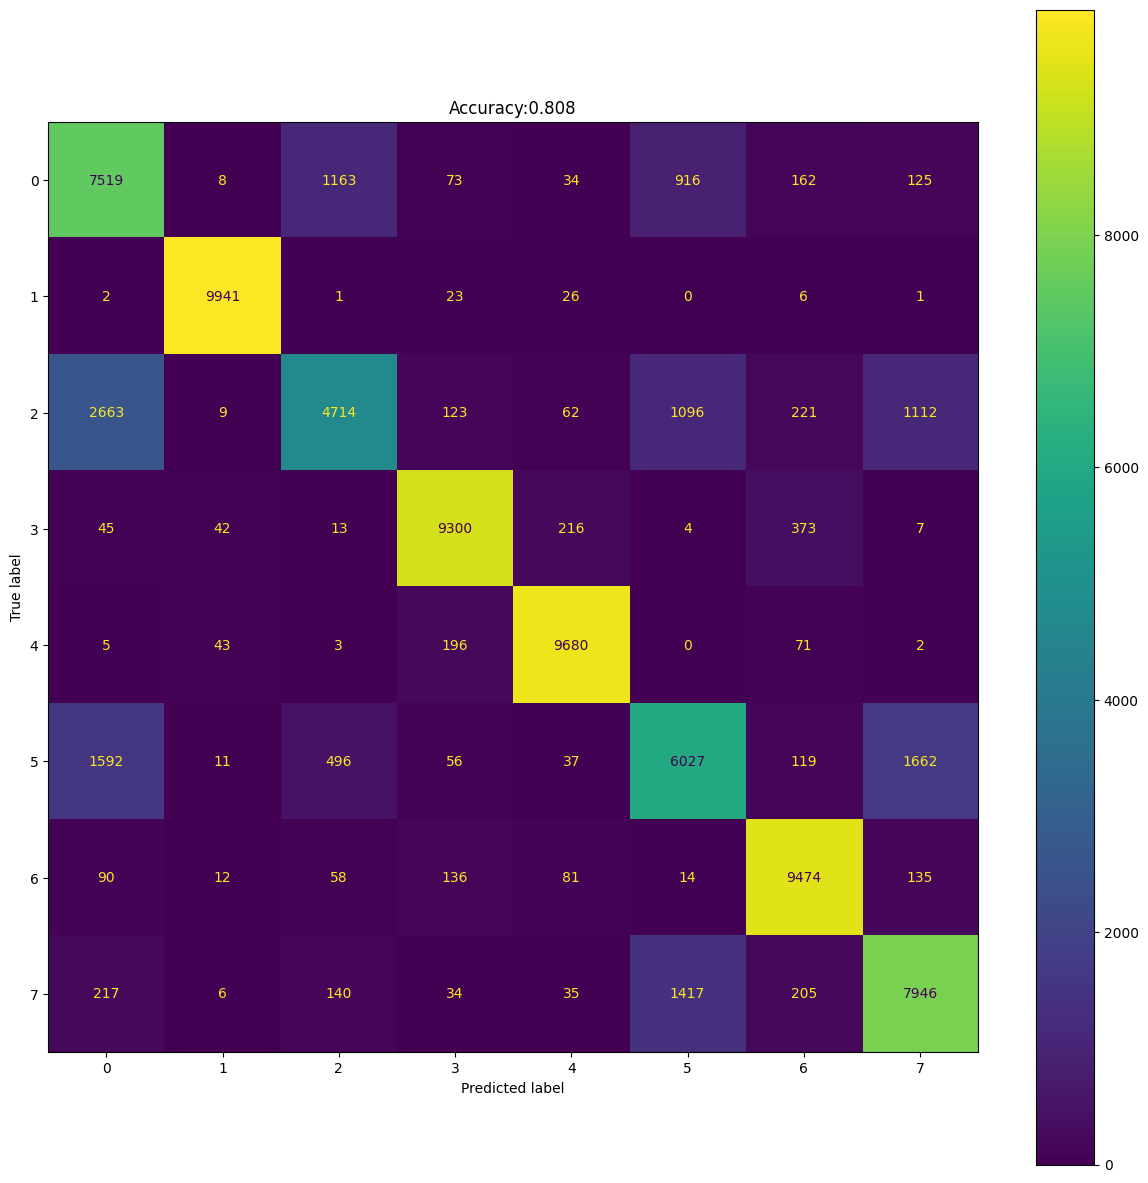

In [17]:
# confusion matrix plot
plt.rcParams["figure.figsize"] = (15,15)
fig, axs = plt.subplots(1)

test_acc = metrics.accuracy_score(y_pred,Y)
print(f"Test Accuracy:{test_acc}")
metrics.ConfusionMatrixDisplay.from_predictions(Y, y_pred, ax=axs)
plt.title(f"Accuracy:{test_acc:.3f}")
# plt.savefig(f'/Users/Lojenaa/Documents/PhD/Smartphones/Cross-device-Portability-of-EMSCA/Nordic/Device-25/iNordic-25(i)_confusion_matrix.pdf')

## Cross-model Validation applying the Model of other Device samples

Nordic Device-25(ii) model to Nordic Device-30(i) dataset 

In [18]:
model = keras.models.load_model("/Users/Lojenaa/Documents/PhD/Smartphones/Cross-device-Portability-of-EMSCA/Nordic/2.4GHz/Device-25/Nordic-device-25-Own_models/Nordic-25(ii)_model.h5")

In [19]:
results = model.evaluate(X, Y)
print("test loss, test acc:", results)

2500/2500 [==============================] - 10s 4ms/step - loss: 8.8868 - accuracy: 0.2587
test loss, test acc: [8.886795997619629, 0.25870001316070557]


In [20]:
y_pred = np.argmax(model.predict(X), axis=-1)
print(y_pred)
print(y_pred[0])

print(confusion_matrix(Y, y_pred))
print(classification_report(Y, y_pred))

2500/2500 [==============================] - 10s 4ms/step
[3 6 6 ... 6 3 3]
3
[[   0   18    1 7053    0   17 2909    2]
 [   1 8858  498    7    5  604   26    1]
 [   0   15    0 1436    0   29 8516    4]
 [   0   43    0 2806    1   36 7111    3]
 [   3  668    2  293    4  156 8872    2]
 [   0    6    0  636    0   20 9338    0]
 [   1   15    0  954    0   24 9002    4]
 [   1   11    0 8253    0   11 1718    6]]
              precision    recall  f1-score   support

           0       0.00      0.00      0.00     10000
           1       0.92      0.89      0.90     10000
           2       0.00      0.00      0.00     10000
           3       0.13      0.28      0.18     10000
           4       0.40      0.00      0.00     10000
           5       0.02      0.00      0.00     10000
           6       0.19      0.90      0.31     10000
           7       0.27      0.00      0.00     10000

    accuracy                           0.26     80000
   macro avg       0.24      0.26  

Test Accuracy:0.2587


Text(0.5, 1.0, 'Accuracy:0.259')

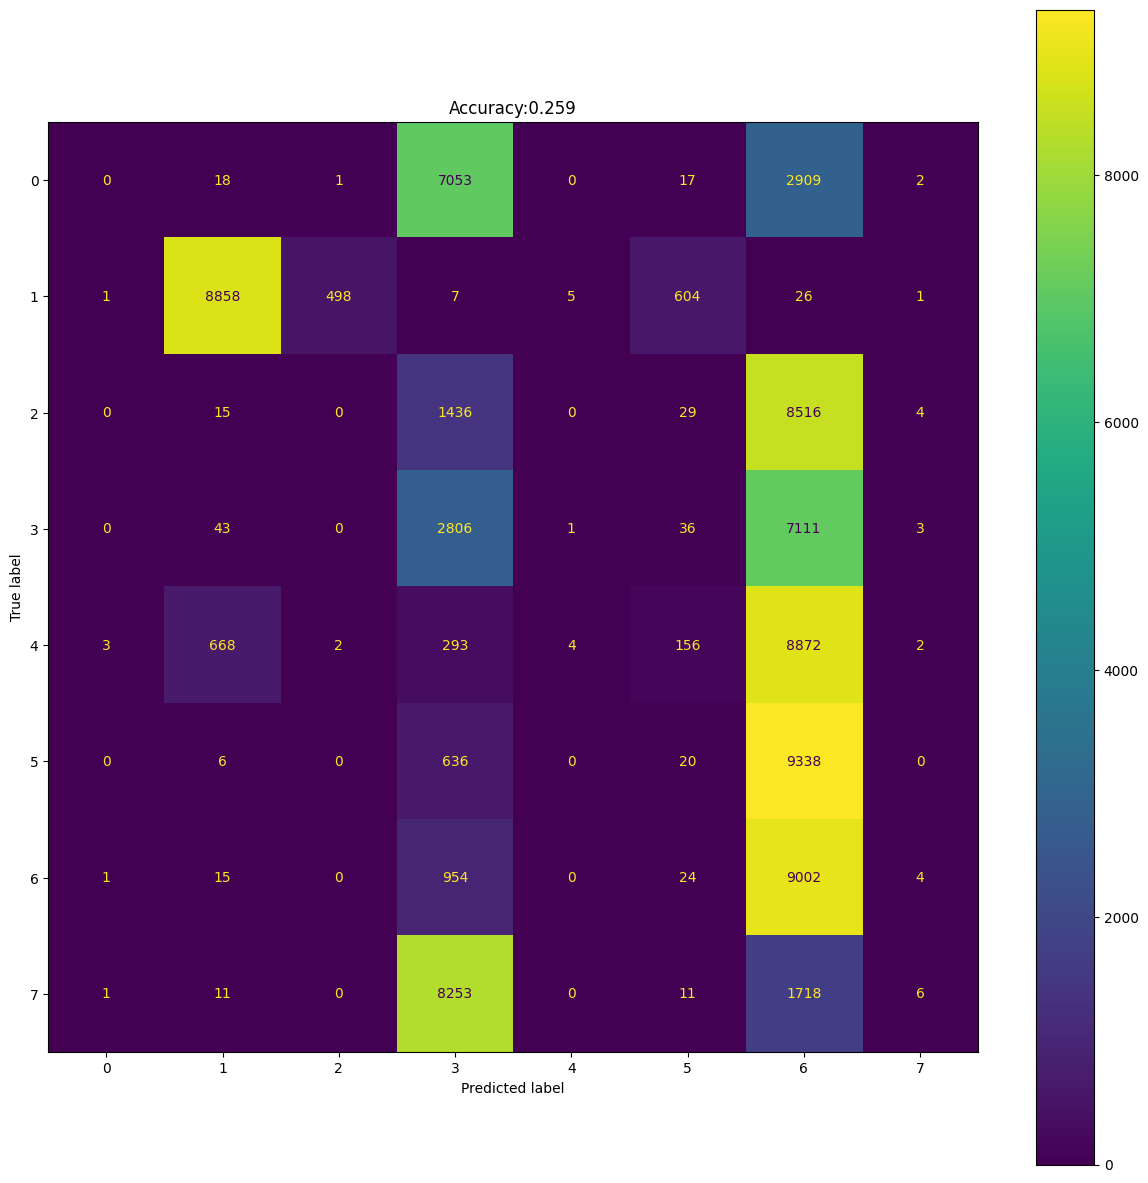

In [21]:
# confusion matrix plot
plt.rcParams["figure.figsize"] = (15,15)
fig, axs = plt.subplots(1)

test_acc = metrics.accuracy_score(y_pred,Y)
print(f"Test Accuracy:{test_acc}")
metrics.ConfusionMatrixDisplay.from_predictions(Y, y_pred, ax=axs)
plt.title(f"Accuracy:{test_acc:.3f}")
# plt.savefig(f'/Users/Lojenaa/Documents/PhD/Smartphones/Cross-device-Portability-of-EMSCA/Nordic/Device-25/iNordic-25(i)_confusion_matrix.pdf')

## Cross-model Validation by applying Transfer Learning of other Device's Model

In [22]:
model = keras.models.load_model("/Users/Lojenaa/Documents/PhD/Smartphones/Cross-device-Portability-of-EMSCA/Nordic/2.4GHz/Device-25/Nordic-device-25-Own_models/Nordic-25(ii)_model.h5")
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_6 (Dense)             (None, 1400)              2868600   
                                                                 
 dense_7 (Dense)             (None, 800)               1120800   
                                                                 
 dense_8 (Dense)             (None, 500)               400500    
                                                                 
 dense_9 (Dense)             (None, 200)               100200    
                                                                 
 dense_10 (Dense)            (None, 100)               20100     
                                                                 
 dense_11 (Dense)            (None, 8)                 808       
                                                                 
Total params: 4,511,008
Trainable params: 4,511,008
No

In [23]:
# Freeze all layers except the last one.
for layer in model.layers[:-1]:
  layer.trainable = False

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_6 (Dense)             (None, 1400)              2868600   
                                                                 
 dense_7 (Dense)             (None, 800)               1120800   
                                                                 
 dense_8 (Dense)             (None, 500)               400500    
                                                                 
 dense_9 (Dense)             (None, 200)               100200    
                                                                 
 dense_10 (Dense)            (None, 100)               20100     
                                                                 
 dense_11 (Dense)            (None, 8)                 808       
                                                                 
Total params: 4,511,008
Trainable params: 808
Non-trai

In [24]:
opt = keras.optimizers.SGD(learning_rate=0.001)
model.compile(loss="sparse_categorical_crossentropy", optimizer=opt, metrics=["accuracy"])

history = model.fit(X, Y, epochs=30)

Epoch 1/30
2500/2500 [==============================] - 13s 5ms/step - loss: 2.0350 - accuracy: 0.3532
Epoch 2/30
2500/2500 [==============================] - 10s 4ms/step - loss: 1.2429 - accuracy: 0.5803
Epoch 3/30
2500/2500 [==============================] - 10s 4ms/step - loss: 1.1601 - accuracy: 0.6393
Epoch 4/30
2500/2500 [==============================] - 10s 4ms/step - loss: 1.1248 - accuracy: 0.6541
Epoch 5/30
2500/2500 [==============================] - 10s 4ms/step - loss: 1.1008 - accuracy: 0.6633
Epoch 6/30
2500/2500 [==============================] - 10s 4ms/step - loss: 1.0822 - accuracy: 0.6692
Epoch 7/30
2500/2500 [==============================] - 10s 4ms/step - loss: 1.0669 - accuracy: 0.6764
Epoch 8/30
2500/2500 [==============================] - 10s 4ms/step - loss: 1.0537 - accuracy: 0.6830
Epoch 9/30
2500/2500 [==============================] - 10s 4ms/step - loss: 1.0421 - accuracy: 0.6892
Epoch 10/30
2500/2500 [==============================] - 10s 4ms/step - l

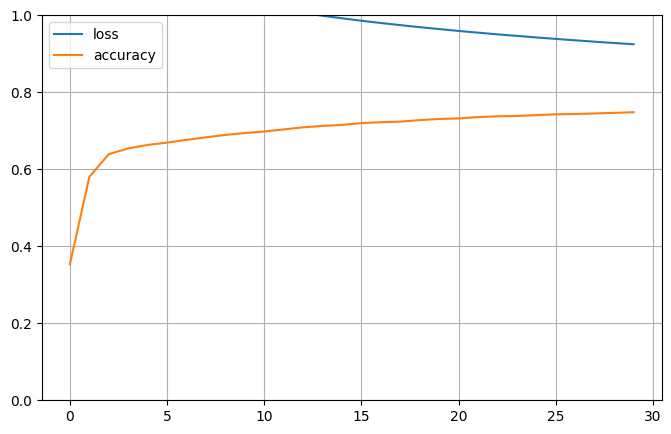

In [25]:
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1) # set the vertical range to [0-1]
plt.show()

In [26]:
results = model.evaluate(X, Y)
print("test loss, test acc:", results)

2500/2500 [==============================] - 11s 4ms/step - loss: 0.9226 - accuracy: 0.7536
test loss, test acc: [0.9226312637329102, 0.7536374926567078]


In [27]:
y_pred = np.argmax(model.predict(X), axis=-1)
print(y_pred)
print(y_pred[0])

print(confusion_matrix(Y, y_pred))
print(classification_report(Y, y_pred))

2500/2500 [==============================] - 11s 4ms/step
[7 0 0 ... 5 7 7]
7
[[5578   14  846  126  109  423  513 2391]
 [   1 9918    0    3   78    0    0    0]
 [1411   14 2989  112  121 4043  624  686]
 [ 406   13   25 7947  387   10 1203    9]
 [  12   90    1  435 9431    4   24    3]
 [ 249   12  862   52   71 8127   96  531]
 [ 625   13  804  241  145  125 8028   19]
 [ 581    9  152   98   48  764   75 8273]]
              precision    recall  f1-score   support

           0       0.63      0.56      0.59     10000
           1       0.98      0.99      0.99     10000
           2       0.53      0.30      0.38     10000
           3       0.88      0.79      0.84     10000
           4       0.91      0.94      0.93     10000
           5       0.60      0.81      0.69     10000
           6       0.76      0.80      0.78     10000
           7       0.69      0.83      0.76     10000

    accuracy                           0.75     80000
   macro avg       0.75      0.75  

Test Accuracy:0.7536375


Text(0.5, 1.0, 'Accuracy:0.754')

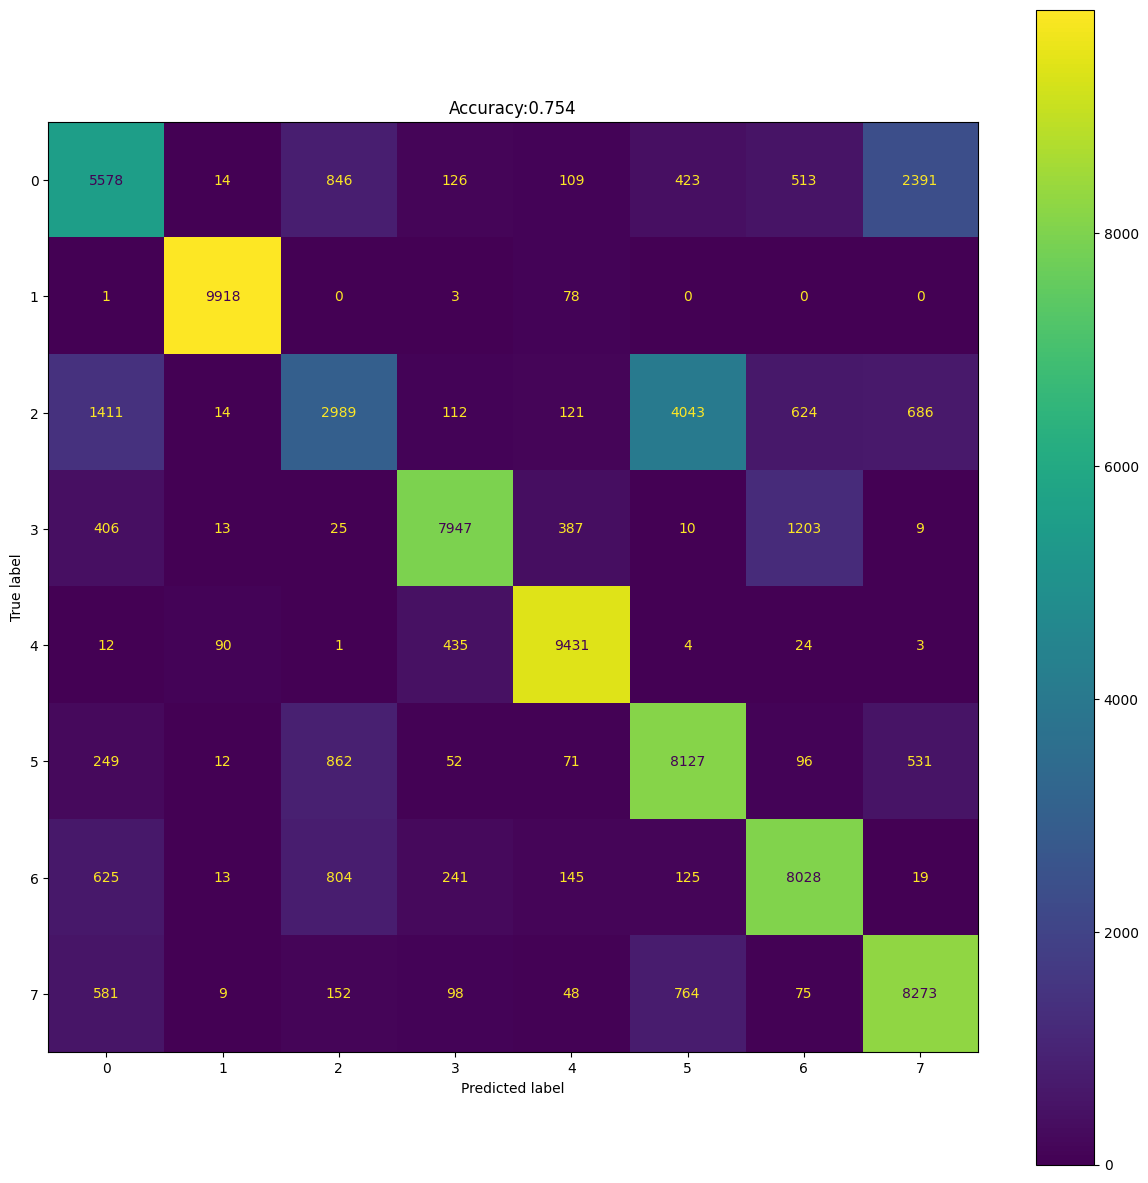

In [28]:
# confusion matrix plot
plt.rcParams["figure.figsize"] = (15,15)
fig, axs = plt.subplots(1)

test_acc = metrics.accuracy_score(y_pred,Y)
print(f"Test Accuracy:{test_acc}")
metrics.ConfusionMatrixDisplay.from_predictions(Y, y_pred, ax=axs)
plt.title(f"Accuracy:{test_acc:.3f}")
# plt.savefig(f'/Users/Lojenaa/Documents/PhD/Smartphones/Cross-device-Portability-of-EMSCA/Nordic/Device-25/iNordic-25(i)_confusion_matrix.pdf')

Nordic Device-25(iii) model to Nordic Device-30(i) dataset 

In [30]:
model = keras.models.load_model("/Users/Lojenaa/Documents/PhD/Smartphones/Cross-device-Portability-of-EMSCA/Nordic/2.4GHz/Device-25/Nordic-device-25-Own_models/Nordic-25(iii)_model.h5")

In [31]:
results = model.evaluate(X, Y)
print("test loss, test acc:", results)

2500/2500 [==============================] - 13s 5ms/step - loss: 12.7289 - accuracy: 0.0214
test loss, test acc: [12.728850364685059, 0.021375000476837158]


In [32]:
y_pred = np.argmax(model.predict(X), axis=-1)
print(y_pred)
print(y_pred[0])

print(confusion_matrix(Y, y_pred))
print(classification_report(Y, y_pred))

2500/2500 [==============================] - 13s 5ms/step
[3 3 3 ... 3 3 3]
3
[[   0   28    1 9769   12    0  190    0]
 [   5 1007    0    1    9 7420   10 1548]
 [   0   72    2 9738   18    2  167    1]
 [   0 1461    4   70   24    0 8441    0]
 [   0 8206    9   10  445   13 1315    2]
 [   0   34    0 9863   16    0   86    1]
 [   0  207    0 9574   30    3  186    0]
 [   0   40    2 9826   22    0  110    0]]
              precision    recall  f1-score   support

           0       0.00      0.00      0.00     10000
           1       0.09      0.10      0.10     10000
           2       0.11      0.00      0.00     10000
           3       0.00      0.01      0.00     10000
           4       0.77      0.04      0.08     10000
           5       0.00      0.00      0.00     10000
           6       0.02      0.02      0.02     10000
           7       0.00      0.00      0.00     10000

    accuracy                           0.02     80000
   macro avg       0.12      0.02  

Test Accuracy:0.021375


Text(0.5, 1.0, 'Accuracy:0.021')

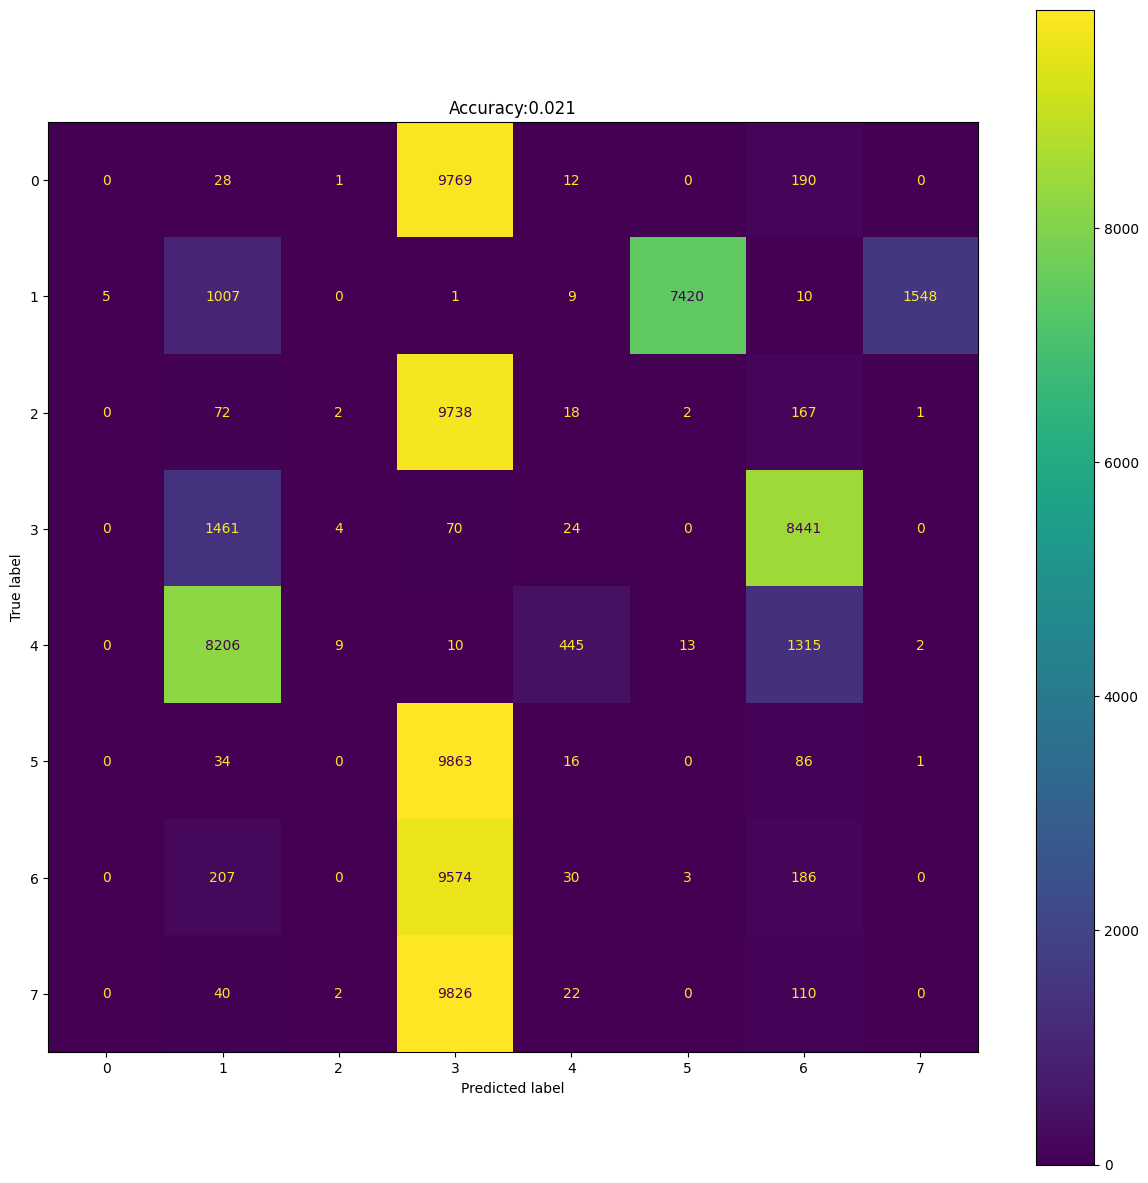

In [33]:
# confusion matrix plot
plt.rcParams["figure.figsize"] = (15,15)
fig, axs = plt.subplots(1)

test_acc = metrics.accuracy_score(y_pred,Y)
print(f"Test Accuracy:{test_acc}")
metrics.ConfusionMatrixDisplay.from_predictions(Y, y_pred, ax=axs)
plt.title(f"Accuracy:{test_acc:.3f}")
# plt.savefig(f'/Users/Lojenaa/Documents/PhD/Smartphones/Cross-device-Portability-of-EMSCA/Nordic/Device-25/iNordic-25(i)_confusion_matrix.pdf')

## Cross-model Validation by applying Transfer Learning @2.4GHz

Nordic Device-25(iii) model to Nordic Device-30(i) dataset 

In [34]:
model = keras.models.load_model("/Users/Lojenaa/Documents/PhD/Smartphones/Cross-device-Portability-of-EMSCA/Nordic/2.4GHz/Device-25/Nordic-device-25-Own_models/Nordic-25(iii)_model.h5")
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_12 (Dense)            (None, 1400)              2868600   
                                                                 
 dense_13 (Dense)            (None, 800)               1120800   
                                                                 
 dense_14 (Dense)            (None, 500)               400500    
                                                                 
 dense_15 (Dense)            (None, 200)               100200    
                                                                 
 dense_16 (Dense)            (None, 100)               20100     
                                                                 
 dense_17 (Dense)            (None, 8)                 808       
                                                                 
Total params: 4,511,008
Trainable params: 4,511,008
No

In [35]:
# Freeze all layers except the last one.
for layer in model.layers[:-1]:
  layer.trainable = False

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_12 (Dense)            (None, 1400)              2868600   
                                                                 
 dense_13 (Dense)            (None, 800)               1120800   
                                                                 
 dense_14 (Dense)            (None, 500)               400500    
                                                                 
 dense_15 (Dense)            (None, 200)               100200    
                                                                 
 dense_16 (Dense)            (None, 100)               20100     
                                                                 
 dense_17 (Dense)            (None, 8)                 808       
                                                                 
Total params: 4,511,008
Trainable params: 808
Non-trai

In [36]:
opt = keras.optimizers.SGD(learning_rate=0.001)
model.compile(loss="sparse_categorical_crossentropy", optimizer=opt, metrics=["accuracy"])

history = model.fit(X, Y, epochs=30)

Epoch 1/30
2500/2500 [==============================] - 13s 5ms/step - loss: 2.5439 - accuracy: 0.3544
Epoch 2/30
2500/2500 [==============================] - 10s 4ms/step - loss: 1.1302 - accuracy: 0.6392
Epoch 3/30
2500/2500 [==============================] - 10s 4ms/step - loss: 1.0000 - accuracy: 0.7305
Epoch 4/30
2500/2500 [==============================] - 10s 4ms/step - loss: 0.9283 - accuracy: 0.7529
Epoch 5/30
2500/2500 [==============================] - 10s 4ms/step - loss: 0.8811 - accuracy: 0.7632
Epoch 6/30
2500/2500 [==============================] - 10s 4ms/step - loss: 0.8471 - accuracy: 0.7719
Epoch 7/30
2500/2500 [==============================] - 12s 5ms/step - loss: 0.8209 - accuracy: 0.7772
Epoch 8/30
2500/2500 [==============================] - 10s 4ms/step - loss: 0.7998 - accuracy: 0.7848
Epoch 9/30
2500/2500 [==============================] - 10s 4ms/step - loss: 0.7823 - accuracy: 0.7919
Epoch 10/30
2500/2500 [==============================] - 10s 4ms/step - l

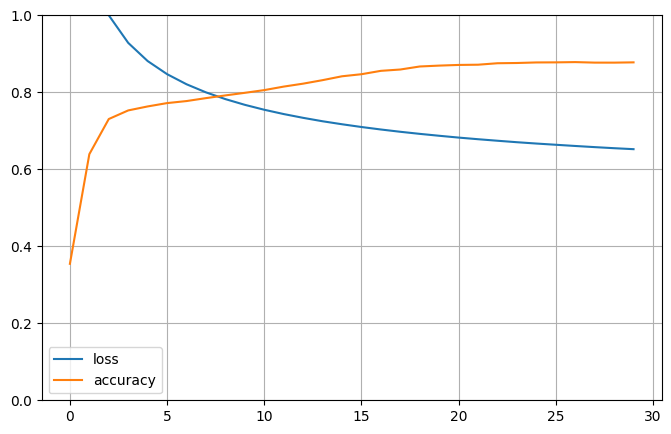

In [37]:
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1) # set the vertical range to [0-1]
plt.show()

In [38]:
results = model.evaluate(X, Y)
print("test loss, test acc:", results)

2500/2500 [==============================] - 11s 4ms/step - loss: 0.6505 - accuracy: 0.8890
test loss, test acc: [0.6505146622657776, 0.8889999985694885]


In [39]:
y_pred = np.argmax(model.predict(X), axis=-1)
print(y_pred)
print(y_pred[0])

print(confusion_matrix(Y, y_pred))
print(classification_report(Y, y_pred))

2500/2500 [==============================] - 12s 5ms/step
[5 0 0 ... 7 7 7]
5
[[7252    0  509   79   13  787  708  652]
 [   0 9931    1    9   24    0   35    0]
 [ 607    2 7167  101   28  661  524  910]
 [   0   13   36 9482  335    5  119   10]
 [   0   58    7  378 9500    1   55    1]
 [  91    2  186   60   18 9301  121  221]
 [ 139    5  144  113   36  238 9308   17]
 [  48    2  247   52   22  292  158 9179]]
              precision    recall  f1-score   support

           0       0.89      0.73      0.80     10000
           1       0.99      0.99      0.99     10000
           2       0.86      0.72      0.78     10000
           3       0.92      0.95      0.94     10000
           4       0.95      0.95      0.95     10000
           5       0.82      0.93      0.87     10000
           6       0.84      0.93      0.89     10000
           7       0.84      0.92      0.87     10000

    accuracy                           0.89     80000
   macro avg       0.89      0.89  

Test Accuracy:0.889


Text(0.5, 1.0, 'Accuracy:0.889')

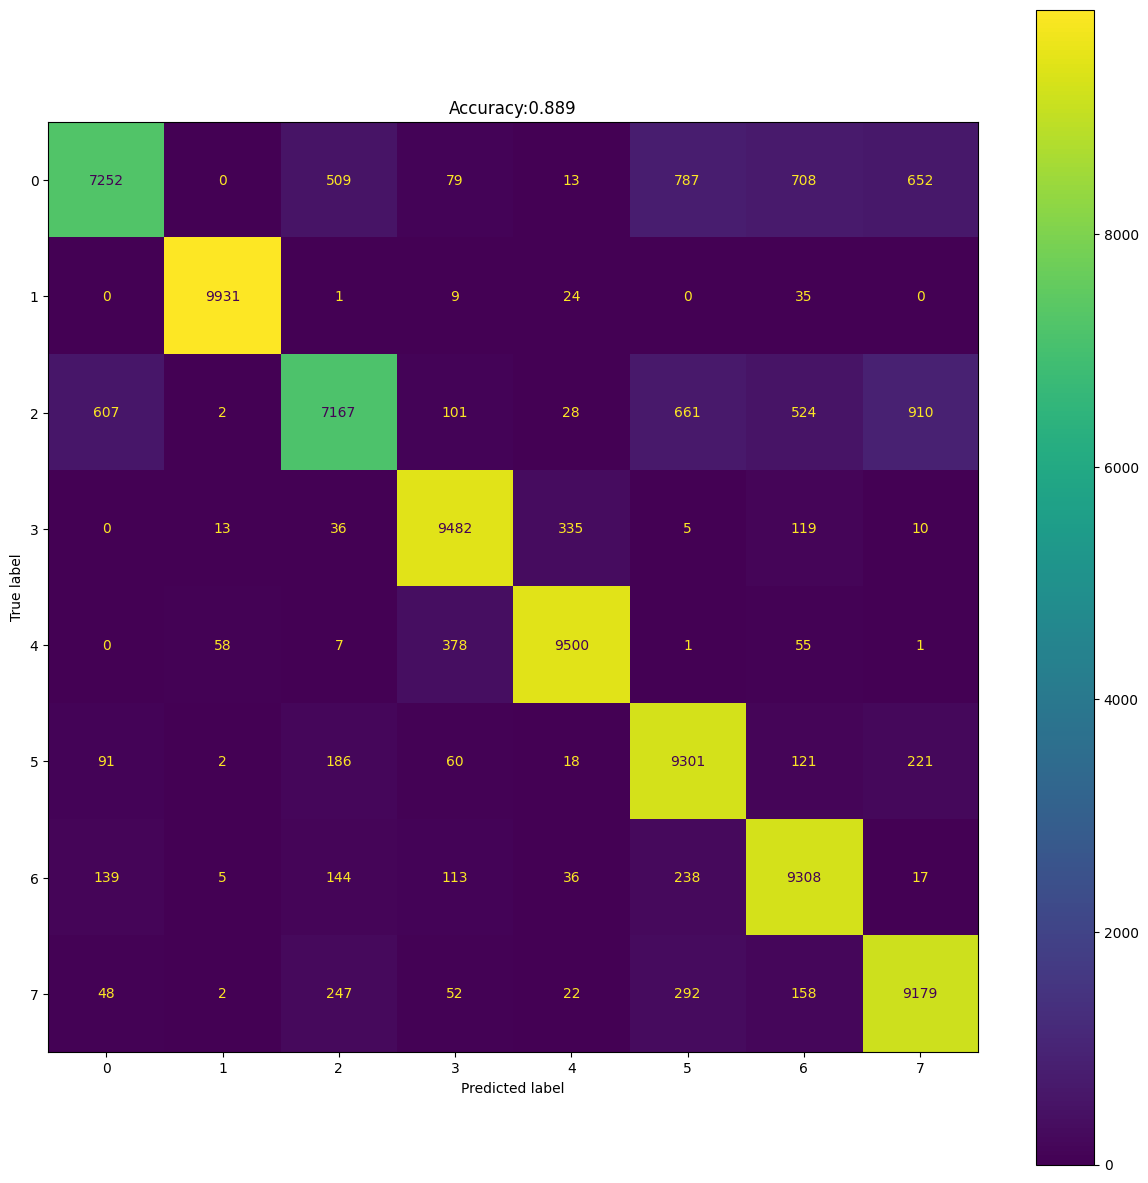

In [40]:
# confusion matrix plot
plt.rcParams["figure.figsize"] = (15,15)
fig, axs = plt.subplots(1)

test_acc = metrics.accuracy_score(y_pred,Y)
print(f"Test Accuracy:{test_acc}")
metrics.ConfusionMatrixDisplay.from_predictions(Y, y_pred, ax=axs)
plt.title(f"Accuracy:{test_acc:.3f}")
# plt.savefig(f'/Users/Lojenaa/Documents/PhD/Smartphones/Cross-device-Portability-of-EMSCA/Nordic/Device-25/iNordic-25(i)_confusion_matrix.pdf')

## Smae Device Other set of Models

Nordic Device-30(ii) model to Nordic Device-30(i) dataset 

In [41]:
model = keras.models.load_model("/Users/Lojenaa/Documents/PhD/Smartphones/Cross-device-Portability-of-EMSCA/Nordic/2.4GHz/Device-30/Nordic-device-30-Own_models/Nordic-30(ii)_model.h5")

In [42]:
results = model.evaluate(X, Y)
print("test loss, test acc:", results)

2500/2500 [==============================] - 11s 4ms/step - loss: 4.5563 - accuracy: 0.1263
test loss, test acc: [4.556268692016602, 0.12628750503063202]


In [43]:
y_pred = np.argmax(model.predict(X), axis=-1)
print(y_pred)
print(y_pred[0])

print(confusion_matrix(Y, y_pred))
print(classification_report(Y, y_pred))

2500/2500 [==============================] - 12s 5ms/step
[7 2 2 ... 2 2 2]
7
[[  44    0 6639    0    1 1435 1874    7]
 [  46 3950    1 5976   13   13    1    0]
 [  70    0 2427    1    5 1923 5561   13]
 [9831    2   26   16   11   35   78    1]
 [1393   22   13 8532   17   10   10    3]
 [  17    0 9012    0    1  376  588    6]
 [6467    0  129    0    9  125 3265    5]
 [  39    0 9559    0    0   48  346    8]]
              precision    recall  f1-score   support

           0       0.00      0.00      0.00     10000
           1       0.99      0.40      0.57     10000
           2       0.09      0.24      0.13     10000
           3       0.00      0.00      0.00     10000
           4       0.30      0.00      0.00     10000
           5       0.09      0.04      0.05     10000
           6       0.28      0.33      0.30     10000
           7       0.19      0.00      0.00     10000

    accuracy                           0.13     80000
   macro avg       0.24      0.13  

Test Accuracy:0.1262875


Text(0.5, 1.0, 'Accuracy:0.126')

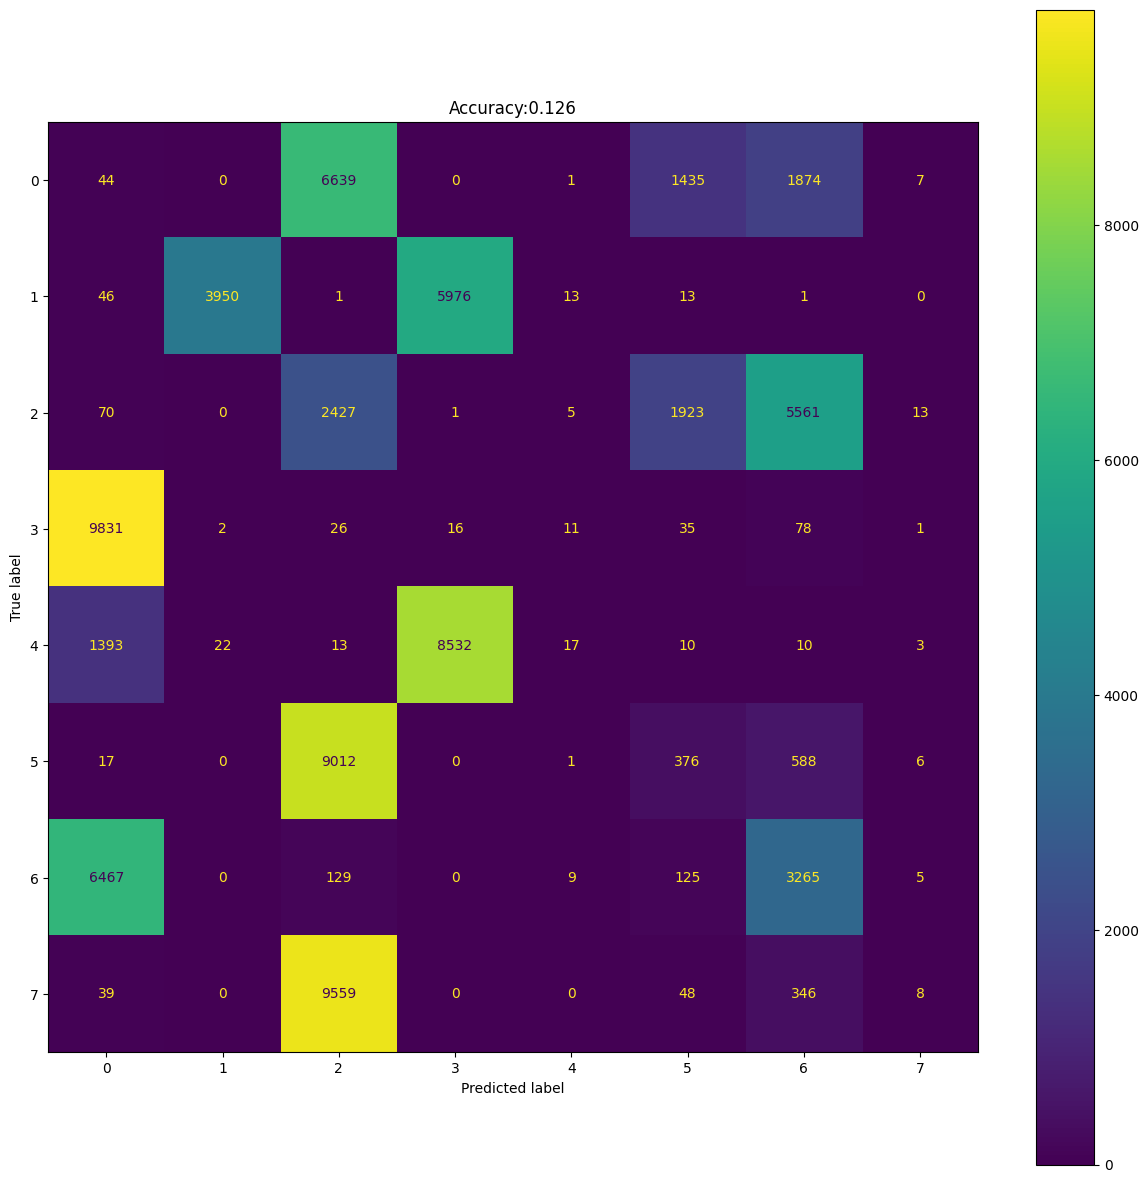

In [44]:
# confusion matrix plot
plt.rcParams["figure.figsize"] = (15,15)
fig, axs = plt.subplots(1)

test_acc = metrics.accuracy_score(y_pred,Y)
print(f"Test Accuracy:{test_acc}")
metrics.ConfusionMatrixDisplay.from_predictions(Y, y_pred, ax=axs)
plt.title(f"Accuracy:{test_acc:.3f}")
# plt.savefig(f'/Users/Lojenaa/Documents/PhD/Smartphones/Cross-device-Portability-of-EMSCA/Nordic/Device-25/iNordic-25(i)_confusion_matrix.pdf')

## Cross-model Validation applying the Model of other set of samples

In [45]:
model = keras.models.load_model("/Users/Lojenaa/Documents/PhD/Smartphones/Cross-device-Portability-of-EMSCA/Nordic/2.4GHz/Device-30/Nordic-device-30-Own_models/Nordic-30(ii)_model.h5")
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 1400)              2868600   
                                                                 
 dense_1 (Dense)             (None, 800)               1120800   
                                                                 
 dense_2 (Dense)             (None, 500)               400500    
                                                                 
 dense_3 (Dense)             (None, 200)               100200    
                                                                 
 dense_4 (Dense)             (None, 100)               20100     
                                                                 
 dense_5 (Dense)             (None, 8)                 808       
                                                                 
Total params: 4,511,008
Trainable params: 4,511,008
Non-

In [46]:
# Freeze all layers except the last one.
for layer in model.layers[:-1]:
  layer.trainable = False

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 1400)              2868600   
                                                                 
 dense_1 (Dense)             (None, 800)               1120800   
                                                                 
 dense_2 (Dense)             (None, 500)               400500    
                                                                 
 dense_3 (Dense)             (None, 200)               100200    
                                                                 
 dense_4 (Dense)             (None, 100)               20100     
                                                                 
 dense_5 (Dense)             (None, 8)                 808       
                                                                 
Total params: 4,511,008
Trainable params: 808
Non-traina

In [47]:
opt = keras.optimizers.SGD(learning_rate=0.001)
model.compile(loss="sparse_categorical_crossentropy", optimizer=opt, metrics=["accuracy"])

history = model.fit(X, Y, epochs=30)

Epoch 1/30
2500/2500 [==============================] - 14s 5ms/step - loss: 1.1815 - accuracy: 0.5954
Epoch 2/30
2500/2500 [==============================] - 11s 4ms/step - loss: 0.7185 - accuracy: 0.7487
Epoch 3/30
2500/2500 [==============================] - 10s 4ms/step - loss: 0.6621 - accuracy: 0.7983
Epoch 4/30
2500/2500 [==============================] - 10s 4ms/step - loss: 0.6380 - accuracy: 0.8121
Epoch 5/30
2500/2500 [==============================] - 10s 4ms/step - loss: 0.6215 - accuracy: 0.8224
Epoch 6/30
2500/2500 [==============================] - 10s 4ms/step - loss: 0.6089 - accuracy: 0.8285
Epoch 7/30
2500/2500 [==============================] - 10s 4ms/step - loss: 0.5987 - accuracy: 0.8349
Epoch 8/30
2500/2500 [==============================] - 10s 4ms/step - loss: 0.5902 - accuracy: 0.8395
Epoch 9/30
2500/2500 [==============================] - 10s 4ms/step - loss: 0.5831 - accuracy: 0.8425
Epoch 10/30
2500/2500 [==============================] - 10s 4ms/step - l

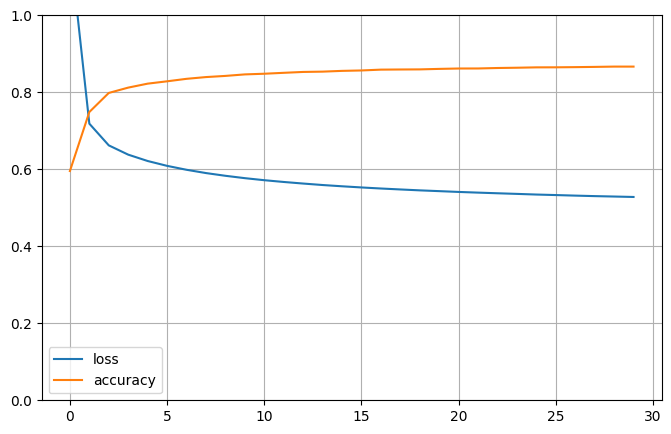

In [48]:
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1) # set the vertical range to [0-1]
plt.show()

In [50]:
results = model.evaluate(X, Y)
print("test loss, test acc:", results)

2500/2500 [==============================] - 11s 4ms/step - loss: 0.5277 - accuracy: 0.8664
test loss, test acc: [0.52769935131073, 0.8664249777793884]


In [51]:
y_pred = np.argmax(model.predict(X), axis=-1)
print(y_pred)
print(y_pred[0])

print(confusion_matrix(Y, y_pred))
print(classification_report(Y, y_pred))

2500/2500 [==============================] - 12s 5ms/step
[7 5 5 ... 5 7 7]
7
[[5844    0 2254   24    0  881   22  975]
 [   4 9905    1   27   60    1    2    0]
 [2352    0 6689   37    3  535   99  285]
 [  41    9   29 9589  137    4  166   25]
 [  15   42    5  150 9760    3   15   10]
 [ 109    0  335   13    0 9053   34  456]
 [  89    1  106  119    8   50 9507  120]
 [ 538    0  132   29    0  314   20 8967]]
              precision    recall  f1-score   support

           0       0.65      0.58      0.62     10000
           1       0.99      0.99      0.99     10000
           2       0.70      0.67      0.68     10000
           3       0.96      0.96      0.96     10000
           4       0.98      0.98      0.98     10000
           5       0.84      0.91      0.87     10000
           6       0.96      0.95      0.96     10000
           7       0.83      0.90      0.86     10000

    accuracy                           0.87     80000
   macro avg       0.86      0.87  

Test Accuracy:0.866425


Text(0.5, 1.0, 'Accuracy:0.866')

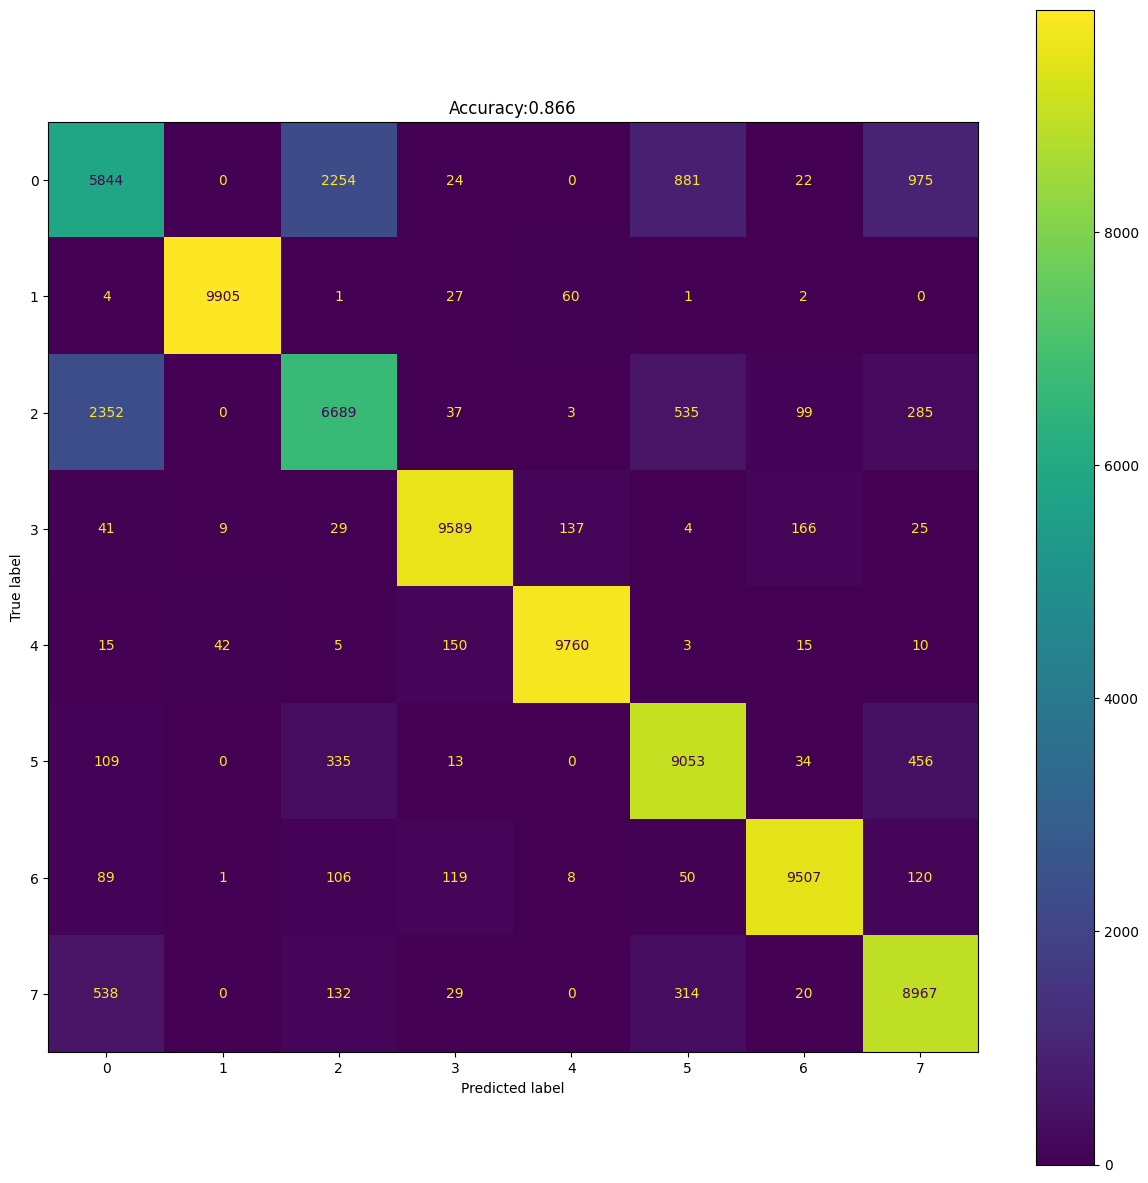

In [52]:
# confusion matrix plot
plt.rcParams["figure.figsize"] = (15,15)
fig, axs = plt.subplots(1)

test_acc = metrics.accuracy_score(y_pred,Y)
print(f"Test Accuracy:{test_acc}")
metrics.ConfusionMatrixDisplay.from_predictions(Y, y_pred, ax=axs)
plt.title(f"Accuracy:{test_acc:.3f}")
# plt.savefig(f'/Users/Lojenaa/Documents/PhD/Smartphones/Cross-device-Portability-of-EMSCA/Nordic/Device-25/iNordic-25(i)_confusion_matrix.pdf')

Nordic Device-30(iii) model to Nordic Device-30(i) dataset 

In [53]:
model = keras.models.load_model("/Users/Lojenaa/Documents/PhD/Smartphones/Cross-device-Portability-of-EMSCA/Nordic/2.4GHz/Device-30/Nordic-device-30-Own_models/Nordic-30(iii)_model.h5")

In [54]:
results = model.evaluate(X, Y)
print("test loss, test acc:", results)

2500/2500 [==============================] - 11s 4ms/step - loss: 6.6129 - accuracy: 0.3965
test loss, test acc: [6.612887382507324, 0.396512508392334]


In [55]:
y_pred = np.argmax(model.predict(X), axis=-1)
print(y_pred)
print(y_pred[0])

print(confusion_matrix(Y, y_pred))
print(classification_report(Y, y_pred))

2500/2500 [==============================] - 11s 5ms/step
[7 5 5 ... 7 7 7]
7
[[   0    0    6   18    3 8078   55 1840]
 [   3 9956   10    0   30    1    0    0]
 [   3    0   12   23    4 8979   35  944]
 [   1    1  821 7470   20 1676    5    6]
 [  14   38 9817   19   89   16    4    3]
 [   0    0    7   11    3 4510   30 5439]
 [   0    0   27   20  197 9675   43   38]
 [   0    0    7   38    2  304    8 9641]]
              precision    recall  f1-score   support

           0       0.00      0.00      0.00     10000
           1       1.00      1.00      1.00     10000
           2       0.00      0.00      0.00     10000
           3       0.98      0.75      0.85     10000
           4       0.26      0.01      0.02     10000
           5       0.14      0.45      0.21     10000
           6       0.24      0.00      0.01     10000
           7       0.54      0.96      0.69     10000

    accuracy                           0.40     80000
   macro avg       0.39      0.40  

Test Accuracy:0.3965125


Text(0.5, 1.0, 'Accuracy:0.397')

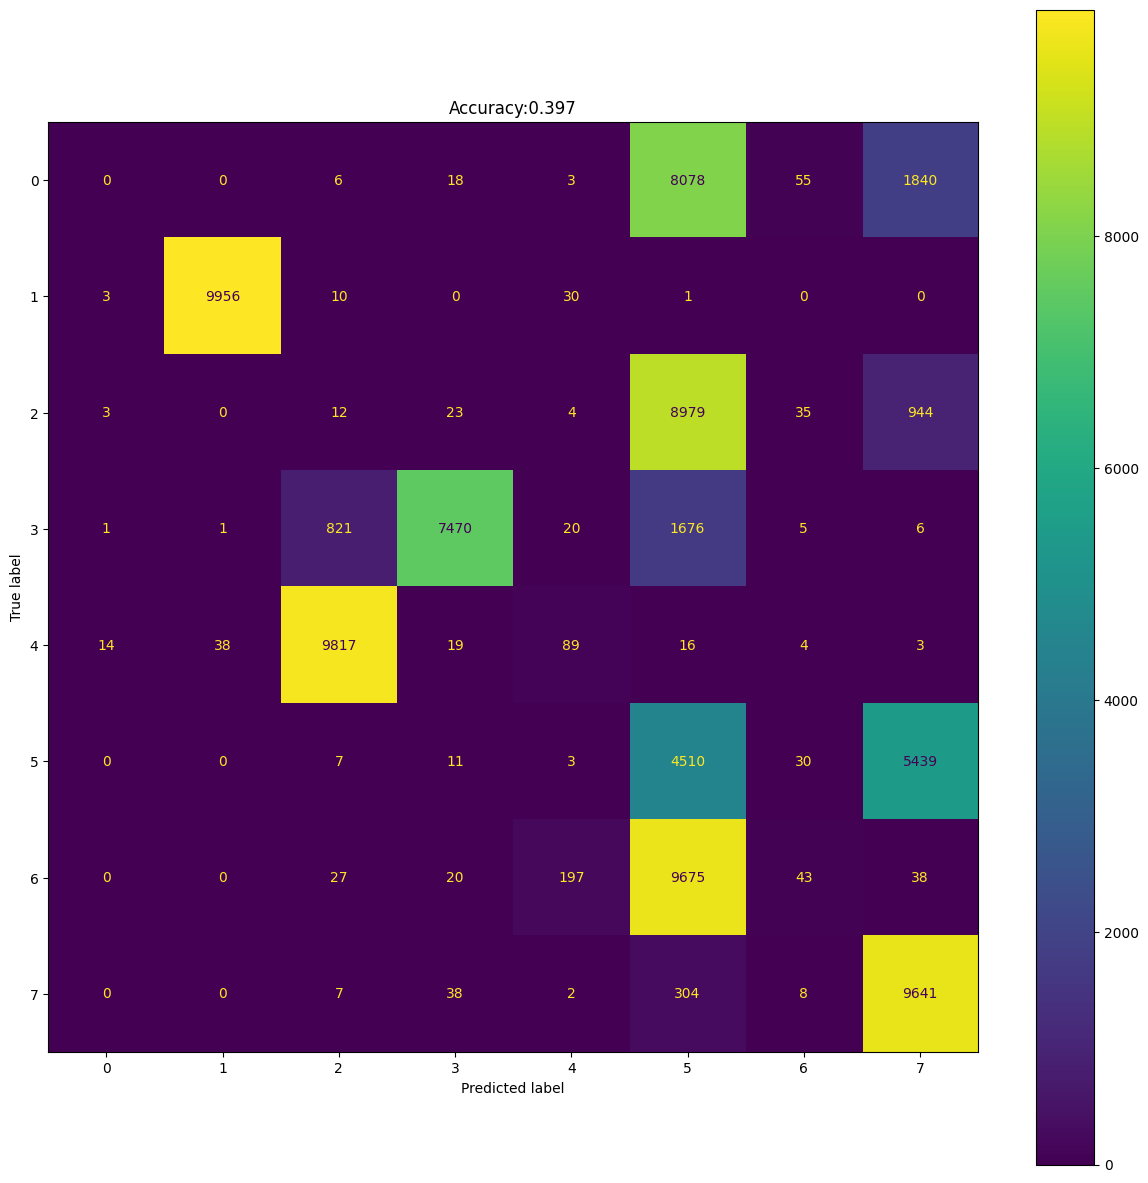

In [56]:
# confusion matrix plot
plt.rcParams["figure.figsize"] = (15,15)
fig, axs = plt.subplots(1)

test_acc = metrics.accuracy_score(y_pred,Y)
print(f"Test Accuracy:{test_acc}")
metrics.ConfusionMatrixDisplay.from_predictions(Y, y_pred, ax=axs)
plt.title(f"Accuracy:{test_acc:.3f}")
# plt.savefig(f'/Users/Lojenaa/Documents/PhD/Smartphones/Cross-device-Portability-of-EMSCA/Nordic/Device-25/iNordic-25(i)_confusion_matrix.pdf')

## Cross-model Validation by applying Transfer Learning of other Device's Model

In [57]:
model = keras.models.load_model("/Users/Lojenaa/Documents/PhD/Smartphones/Cross-device-Portability-of-EMSCA/Nordic/2.4GHz/Device-30/Nordic-device-30-Own_models/Nordic-30(iii)_model.h5")
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_6 (Dense)             (None, 1400)              2868600   
                                                                 
 dense_7 (Dense)             (None, 800)               1120800   
                                                                 
 dense_8 (Dense)             (None, 500)               400500    
                                                                 
 dense_9 (Dense)             (None, 200)               100200    
                                                                 
 dense_10 (Dense)            (None, 100)               20100     
                                                                 
 dense_11 (Dense)            (None, 8)                 808       
                                                                 
Total params: 4,511,008
Trainable params: 4,511,008
No

In [58]:
# Freeze all layers except the last one.
for layer in model.layers[:-1]:
  layer.trainable = False

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_6 (Dense)             (None, 1400)              2868600   
                                                                 
 dense_7 (Dense)             (None, 800)               1120800   
                                                                 
 dense_8 (Dense)             (None, 500)               400500    
                                                                 
 dense_9 (Dense)             (None, 200)               100200    
                                                                 
 dense_10 (Dense)            (None, 100)               20100     
                                                                 
 dense_11 (Dense)            (None, 8)                 808       
                                                                 
Total params: 4,511,008
Trainable params: 808
Non-trai

In [59]:
opt = keras.optimizers.SGD(learning_rate=0.001)
model.compile(loss="sparse_categorical_crossentropy", optimizer=opt, metrics=["accuracy"])

history = model.fit(X, Y, epochs=30)

Epoch 1/30
2500/2500 [==============================] - 13s 5ms/step - loss: 1.2540 - accuracy: 0.6686
Epoch 2/30
2500/2500 [==============================] - 10s 4ms/step - loss: 0.6100 - accuracy: 0.8018
Epoch 3/30
2500/2500 [==============================] - 10s 4ms/step - loss: 0.5717 - accuracy: 0.8193
Epoch 4/30
2500/2500 [==============================] - 10s 4ms/step - loss: 0.5503 - accuracy: 0.8289
Epoch 5/30
2500/2500 [==============================] - 10s 4ms/step - loss: 0.5361 - accuracy: 0.8341
Epoch 6/30
2500/2500 [==============================] - 10s 4ms/step - loss: 0.5256 - accuracy: 0.8342
Epoch 7/30
2500/2500 [==============================] - 10s 4ms/step - loss: 0.5176 - accuracy: 0.8364
Epoch 8/30
2500/2500 [==============================] - 10s 4ms/step - loss: 0.5113 - accuracy: 0.8363
Epoch 9/30
2500/2500 [==============================] - 11s 4ms/step - loss: 0.5064 - accuracy: 0.8380
Epoch 10/30
2500/2500 [==============================] - 10s 4ms/step - l

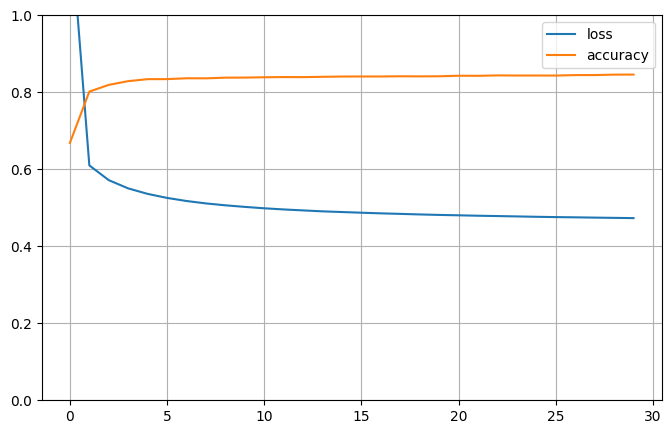

In [60]:
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1) # set the vertical range to [0-1]
plt.show()

In [61]:
results = model.evaluate(X, Y)
print("test loss, test acc:", results)

2500/2500 [==============================] - 11s 4ms/step - loss: 0.4725 - accuracy: 0.8494
test loss, test acc: [0.47246918082237244, 0.8493624925613403]


In [62]:
y_pred = np.argmax(model.predict(X), axis=-1)
print(y_pred)
print(y_pred[0])

print(confusion_matrix(Y, y_pred))
print(classification_report(Y, y_pred))

2500/2500 [==============================] - 11s 4ms/step
[7 5 5 ... 7 7 7]
7
[[4616    0 2759   32    2 2119  113  359]
 [   0 9941    0    1   52    0    6    0]
 [1755    0 6814   52    8  982  142  247]
 [  13    0   23 9754  106    0   93   11]
 [   0   18    5   72 9844    2   58    1]
 [1410    0  337   18    4 7907   52  272]
 [  52    1  116   56    5   30 9710   30]
 [ 180    0  126   42    3  256   30 9363]]
              precision    recall  f1-score   support

           0       0.58      0.46      0.51     10000
           1       1.00      0.99      1.00     10000
           2       0.67      0.68      0.68     10000
           3       0.97      0.98      0.97     10000
           4       0.98      0.98      0.98     10000
           5       0.70      0.79      0.74     10000
           6       0.95      0.97      0.96     10000
           7       0.91      0.94      0.92     10000

    accuracy                           0.85     80000
   macro avg       0.84      0.85  

Test Accuracy:0.8493625


Text(0.5, 1.0, 'Accuracy:0.849')

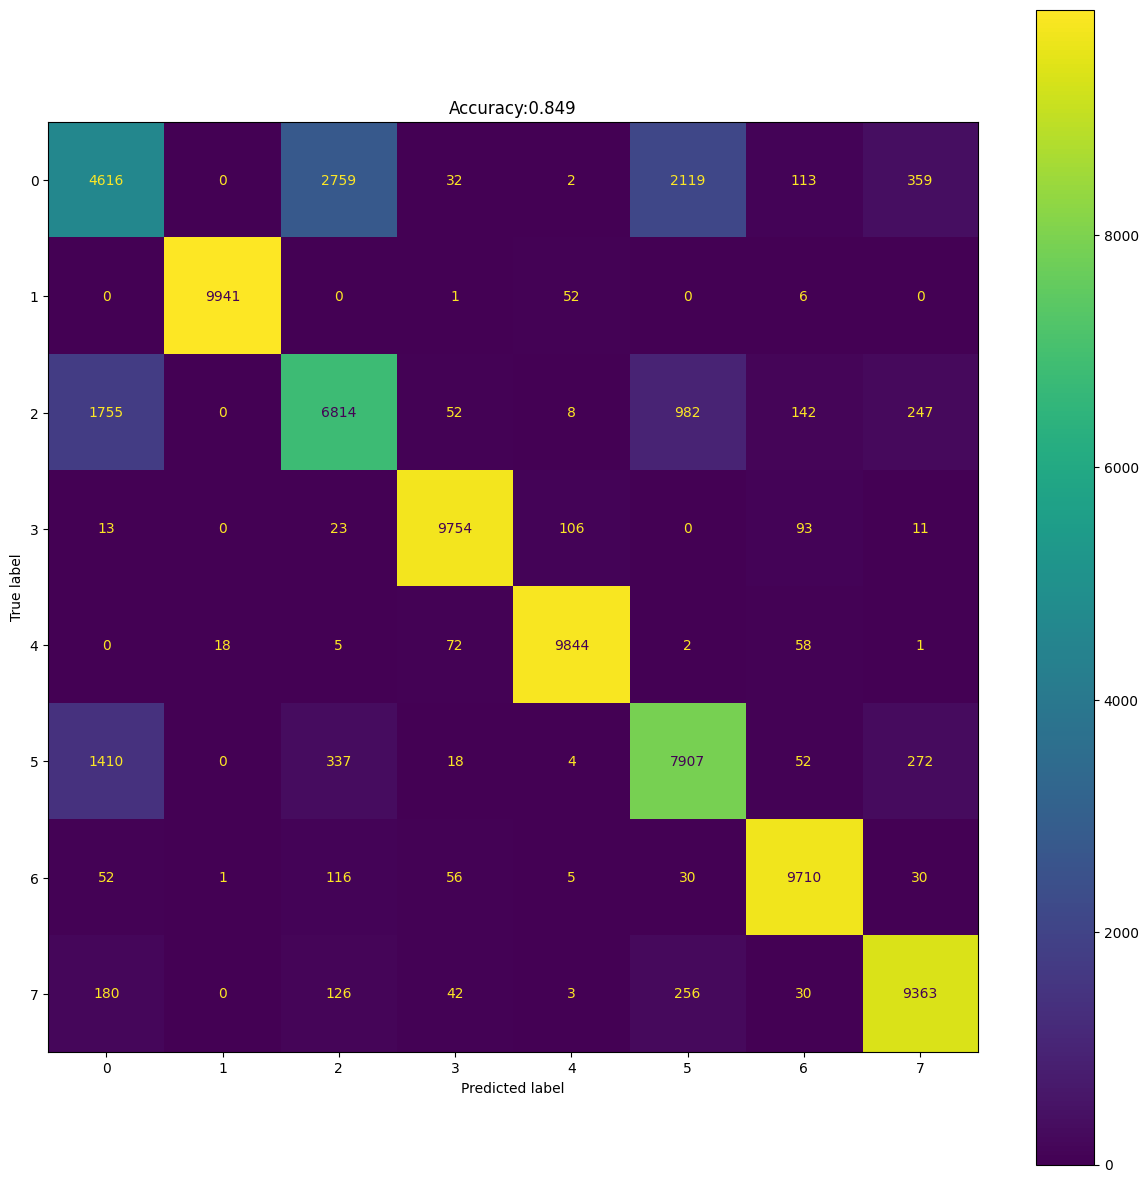

In [63]:
# confusion matrix plot
plt.rcParams["figure.figsize"] = (15,15)
fig, axs = plt.subplots(1)

test_acc = metrics.accuracy_score(y_pred,Y)
print(f"Test Accuracy:{test_acc}")
metrics.ConfusionMatrixDisplay.from_predictions(Y, y_pred, ax=axs)
plt.title(f"Accuracy:{test_acc:.3f}")
# plt.savefig(f'/Users/Lojenaa/Documents/PhD/Smartphones/Cross-device-Portability-of-EMSCA/Nordic/Device-25/iNordic-25(i)_confusion_matrix.pdf')